# Die Corona Lage

## Daten URLs

In [1]:
URL_CORONA_INFECTED = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/" + \
                      "csse_covid_19_data/csse_covid_19_time_series/" + \
                      "time_series_covid19_confirmed_global.csv"
URL_CORONA_RECOVER = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/" + \
                      "csse_covid_19_data/csse_covid_19_time_series/" + \
                      "time_series_covid19_recovered_global.csv"
URL_CORONA_DEATHS = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/" + \
                      "csse_covid_19_data/csse_covid_19_time_series/" + \
                      "time_series_covid19_deaths_global.csv"

## Umsetzung

In [2]:
import csv                       # Intial data parsing (or other/custom)
import datetime                  # Date formatting (optional)
from itertools import zip_longest# Just for pretty printing country names

import numpy as np               # Masking, statistics, diffs
import matplotlib.pyplot as plt  # All plotting
import requests                  # Get data from github

%matplotlib notebook

### Herunterladen der Daten von Github

In [3]:
with requests.get(URL_CORONA_INFECTED) as data:
    infected = list(csv.reader(data.content.decode('utf-8').splitlines(), delimiter=','))
with requests.get(URL_CORONA_RECOVER) as data:
    recovered = list(csv.reader(data.content.decode('utf-8').splitlines(), delimiter=','))
with requests.get(URL_CORONA_DEATHS) as data:
    deaths = list(csv.reader(data.content.decode('utf-8').splitlines(), delimiter=','))

Die Daten haben jetzt folgende Struktur:
```Python
infected = [
    ["Province/State", "Country/Region", "Lat", "Long", "1/22/20", "1/23/20", "1/24/20", ... ],
    [""              , "Afghanistan"   ,  33.0,   65.0,         0,         0,         0, ... ],
    [""              , "Albania"       , 41.15, 20.183,         0,         0,         0, ... ],
     ...
]
```

### Aufreinigen der Daten

* Aus der Infected Tabelle sind die Datumsangaben entnommen
* Daten in eine übersichtliche Dictionary Struktur bringen `data[region][state]["infected"/"recovered"/"deaths"]`.
* Für Länder mit mehreren Provinzen Gesamtzahlen berechnen.
* Für manche Ländern sin für einzelne Provinzen keine *recovered* Zahlen gegeben

In [4]:
# Extraktion der Datumsangaben aus der Kopfzeile der Infizierten
# Mit datetime.datetime.strptime(...) werden die Datumsangaben in ein Datetime-Objekt umgewandelt
dates = [datetime.datetime.strptime(date, "%m/%d/%y").date() for date in infected[0][4:]]

# Jede weitere Zeile enthält die Daten state, region, lat, long und die Infiziertenzahlen
# mit *numbers werden alle weiteren Daten in einer Liste zusammengefasst.
data = {}
for state, region, latitude, longitude, *numbers in infected[1:]:
    numbers = np.array(numbers, dtype=np.int)
    state = state if state != "" else "total" # Wenn kein state gegeben ist, handelt es sich um die absoluten Zahlen.
    if region not in data.keys():             # Wenn ein state gegeben ist, tritt die region mehrfach auf.
        data[region] = {state: {"lat": latitude, "long": longitude, "infected": numbers}}
    else:
        data[region][state] = {"lat": latitude, "long": longitude, "infected": numbers}

# Da für Länder mit mehreren Staaten keine totalen Zahlen gegeben sind. Müssen diese noch berechent werden.
for region, state_data in data.items():
    if len(state_data) > 1:
        state_data["total"] = {"infected": np.sum(np.array([state["infected"]
                                                            for state in state_data.values()]), axis=0)}

# Die recovered und deaths Daten werden ähnlich verarbeitet, es braucht hier jedoch weniger Code.
for state, region, latitude, longitude, *numbers in recovered[1:]:
    numbers = np.array(numbers, dtype=np.int)
    state = state if state != "" else "total"
    data[region][state]["recovered"] = numbers
for state, region, latitude, longitude, *numbers in deaths[1:]:
    numbers = np.array(numbers, dtype=np.int)
    state = state if state != "" else "total"
    data[region][state]["deaths"] = numbers

# Zuletzt müssen wieder die totalen Zahlen berechnet werden.
# Die isinstance() Abfrage verhindert Probleme bei Ländern die ihre Infizierten zwar nach Staaten angeben, die
# Geheilten und Toten jedoch nicht.
for region, state_data in data.items():
    if len(state_data) > 1 and isinstance(state_data["total"].get("recovered", False), bool):
        state_data["total"]["recovered"] = np.sum(np.array([nums["recovered"]
                                                            for state, nums in state_data.items()
                                                            if state != "total"
                                                           ]), axis=0)
    if len(state_data) > 1 and isinstance(state_data["total"].get("deaths", False), bool):
        state_data["total"]["deaths"] = np.sum(np.array([nums["deaths"]
                                                         for state, nums in state_data.items()
                                                         if state != "total"
                                                        ]), axis=0)

In [5]:
def show_countries():
    r"""
        Showing all available countries in the Corona dataset.
    """
    countries = [country if len(country) < 19 else country[:19] + "..." for country in data.keys()]
    args = [iter(countries)] * 5
    print("The dataset contains the following countries:")
    print("\n".join(
                        [' '.join([f"{cntry:<22}" for cntry in group if cntry is not None])
                        for group in zip_longest(*args)]
                   ))

def show_states(country: str):
    r"""
        Showing all available entries for a country in the Corona dataset.
        
        Parameters
        ----------
        country: str
            Country selector.
    """
    states = [state if len(state) < 19 else state[:19] + "..." for state in data[country].keys()]
    print(f"{country} as the following state entries in this dataset:")
    print(" ".join([f"{state:<22}" for state in states]))

### Statistische Auswertung

#### Neue Datensätze

In [6]:
def get_diff_data(country: str, state: str, dtype: str) -> np.ndarray:
    r"""
        Returns the difference in numbers compared to the day before. A 0 is prepended to keep array length.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        dtype: str
            One of "infected"/"recovered"/"deaths" to select the fitting dataset.
        
        Returns
        -------
        ~numpy.ndarray
            The difference data for the selected country, state and type.
    """
    return np.diff(data[country][state][dtype], prepend=[0])

def get_ill_data(country: str, state: str) -> np.ndarray:
    r"""
        Returns the number of currently ill people.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        
        Returns
        -------
        ~numpy.ndarray
            Number of currently ill people for a country and state.
    """
    return data[country][state]["infected"] - data[country][state]["recovered"]

def reproduction_number(country: str, state: str, time_gen: int = 4, last_x_days: int = None) -> np.ndarray:
    r"""
        Returns a simple estimate of the reproduction number R for a country and state. It is calculated with
            R = now / then
        with now being the newly infected on a given day and then being the newly infected time_gen days prior.
        See https://www.spektrum.de/news/was-verraet-die-reproduktionszahl-r-wirklich/1724660 for reference.
        In Case then is 0 R is set to 0.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        time_gen: int = 4
            The virus' generation time, estimated to be 4 Days for SARS-Cov19.
        last_x_days: int = None
            Number of days for which R is to be calculated. All available days if set to None.
    """
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    diff_data = get_diff_data(country, state, "infected")
    if start_idx < time_gen:
        nom = np.concatenate([np.zeros((time_gen - start_idx)), diff_data])[: -time_gen + start_idx]
        denom = diff_data[start_idx:]
    else:
        nom = diff_data[start_idx - time_gen: -time_gen]
        denom = diff_data[start_idx:]
    return np.divide(denom, nom, where=nom > 0, out=nom)

#### Statistik auf Datensätze

In [7]:
def get_diff_max(country: str, state: str, dtype: str) -> float:
    r"""
        Returns the maximum in the daily difference returned by :meth:`get_diff_data`.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        dtype: str
            One of "infected"/"recovered"/"deaths" to select the fitting dataset.
        
        Returns
        -------
        float
            The maximum in daily difference for a given country, state and type.
    """
    return max(get_diff_data(country, state, dtype))

def get_ill_max(country: str, state: str) -> float:
    r"""
        Returns the maximum of active illnesses returned by :meth:`get_ill_data`.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        
        Returns
        -------
        float
            The maximum in daily difference for a given country, state and type.
    """
    return max(get_ill_data(country, state))

def get_diff_mean(country: str, state: str, dtype: str, last_x_days: int = None) -> float:
    r"""
        Returns the mean of the daily difference returned by :meth:`get_diff_data` for a given period.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        dtype: str
            One of "infected"/"recovered"/"deaths" to select the fitting dataset.
        last_x_days: int = None.
            Number of days for the mean is calculated. All available days if set to None.
            
        Returns
        -------
        float
            The mean in daily difference for a given country, state and type.
    """
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    return np.mean(get_diff_data(country, state, dtype)[start_idx:])

def get_ill_mean(country, state, last_x_days=None):
    r"""
        Returns the mean of the currently ill people returned by :meth:`get_ill_data` for a given period.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        dtype: str
            One of "infected"/"recovered"/"deaths" to select the fitting dataset.
        last_x_days: int = None.
            Number of days for the mean is calculated. All available days if set to None.
            
        Returns
        -------
        float
            The mean in ill data for a given country, state and type.
    """
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    return np.mean(get_ill_data(country, state)[start_idx:])

#### Höchstgrenzen

In [8]:
def above_treshold(country: str, state: str, dtype: str, treshold: int) -> tuple:
    r"""
        Finds all days, where data exceeds a given treshold.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        dtype: str
            One of "infected"/"recovered"/"deaths" to select the fitting dataset.
        treshold: int
            Treshold for the given data.
        
        Returns
        -------
        Tuple[~numpy.ndarray, ~numpy.ndarray]
            The days indices and difference data, where data was above the treshold.
    """
    mask = get_diff_data(country, state, dtype) > treshold
    return np.arange(len(dates))[mask], get_diff_data(country, state, dtype)[mask]

def days_above_treshold(country: str, state: str, dtype: str, treshold: int, last_x_days: int = None) -> int:
    r"""
        Calculated the number of days, where the data exceeds a given treshold.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        dtype: str
            One of "infected"/"recovered"/"deaths" to select the fitting dataset.
        treshold: int
            Treshold for the given data.
        last_x_days: int = None.
            Number of days for the mean is calculated. All available days if set to None.
        
        Returns
        -------
        int
            Number of days the treshold was exceeded.
    """
    start_idx = 0 if last_x_days is None else 0 - last_x_days
    return np.sum(get_diff_data(country, state, dtype)[start_idx:] > treshold)

#### Konsolenausgabe aller Daten

In [9]:
def print_statistics(country: str, state: str, treshold: int = False):
    r"""
        Pretty prints the statistics for a given country and state, with an optional treshold value.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        treshold: int = False
            (optional) Treshold for the given data.
    """
    stats = f"""{'#' * (23 + (len(country) + len(state)))}
# Information for {country} - {state} #
{'#' * (23 + (len(country) + len(state)))}

Total Infected: {data[country][state]["infected"][-1]:>10} | Total Recovered: {data[country][state]["recovered"][-1]:>10} | Total Deaths: {data[country][state]["deaths"][-1]:>10}
---------------------------+-----------------------------+-------------------------
Infected Today: {get_diff_data(country, state, "infected")[-1]:>10} | Recovered Today: {get_diff_data(country, state, "infected")[-1]:>10} | Deaths Today: {get_diff_data(country, state, "deaths")[-1]:>10}
Infected Mean Total: {get_diff_mean(country, state, "infected", last_x_days=None):>5.0f} | Recovered Mean Total: {get_diff_mean(country, state, "recovered", last_x_days=None):>5.0f} | Deaths Mean Total: {get_diff_mean(country, state, "deaths", last_x_days=None):>5.0f}
Infected Mean Week: {get_diff_mean(country, state, "infected", last_x_days=7):>6.0f} | Recovered Mean Week: {get_diff_mean(country, state, "recovered", last_x_days=7):>6.0f} | Deaths Mean Week: {get_diff_mean(country, state, "deaths", last_x_days=7):>6.0f}
---------------------------+-----------------------------+-------------------------
Currently Ill: {get_ill_data(country, state)[-1]:>11} | Mean Ill Week: {get_ill_mean(country, state, 7):>12.0f} | Maximum Ill: {get_ill_max(country, state):>11}"""
    if treshold:
        stats += f"\nTreshold: {treshold:>16} | Days Above: {days_above_treshold(country, state, 'infected', treshold):>15} | Days Above Week: {days_above_treshold(country, state, 'infected', treshold, 7):>7}"
    stats += "---------------------------+-----------------------------+-------------------------"
    print(stats)

### Grafische Darstellung

In [10]:
import scipy.ndimage as ndi         # Für die Glättung von Datensätzen
import matplotlib.cm as cm          # Für Colormaps (ScalarMappable)
import matplotlib.colors as colors  # Für Colormaps (Normalize)

In [11]:
def plot_data(country: str, state: str, log: bool = False, ticks: int = 30, **kwargs):
    r"""
        Plots the dataset of infected (yellow), recovered (green) and deaths (red) into a plot.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        log: bool = False
            Switches the y-axis to logarithmic a scale
        ticks: int = 30
            Period of Dates shown on the x-axis. Every *ticks*th day.
        
        Keyword Arguments
        -----------------
        All keyword arguments are passed the :meth:`~matplotlib.pyplot.plot` function.
    """
    plt.title(f"Corona in {country} - {state}")
    plt.plot(range(len(dates)), data[country][state]["infected"], 'y', label="Infected", **kwargs)
    plt.plot(range(len(dates)), data[country][state]["recovered"], 'g', label="recovered", **kwargs)
    plt.plot(range(len(dates)), data[country][state]["deaths"], 'r', label="deaths", **kwargs)
    if log:
        plt.semilogy()
    plt.legend()
    plt.ylim(1 if log else 0, max(data[country][state]["infected"]) * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.ylabel("Total numbers")
    plt.xlabel("Date")

def plot_current_infected(country, state, log=False, ticks=30, **kwargs):
    r"""
        Plots the currently infected data for a country and state.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        log: bool = False
            Switches the y-axis to logarithmic a scale
        ticks: int = 30
            Period of Dates shown on the x-axis. Every *ticks*th day.
            
        Keyword Arguments
        -----------------
        All keyword arguments are passed the :meth:`~matplotlib.pyplot.plot` function.
    """
    plt.title(f"Corona in {country} - {state}")
    plt.plot(range(len(dates)), get_ill_data(country, state), 'k', label="Currently Infected", **kwargs)
    if log:
        plt.semilogy()
    plt.legend()
    plt.ylim(1 if log else 0, max(get_ill_data(country, state)) * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.ylabel("Currently Infected")
    plt.xlabel("Date")
    
def plot_diff(country: str, state: str, dtype: str = "", log: bool=False, ticks: int = 30,
              sigma: float = 0.1, **kwargs):
    r"""
        Plots the dataset of infected (yellow), recovered (green) and deaths (red) into a plot.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        dtype: str = ""
            Selects a specific data type of "infected"/"recovered"/"deaths"
        log: bool = False
            Switches the y-axis to logarithmic a scale
        ticks: int = 30
            Period of Dates shown on the x-axis. Every *ticks*th day.
        sigma: float = 0.1
            (optional) Smoothing width for the gaussian filter applied to the data.
        
        Keyword Arguments
        -----------------
        All keyword arguments are passed the :meth:`~matplotlib.pyplot.plot` function.
    """
    plt.title(f"Corona in {country} - {state}")
    if dtype == "" or dtype == "infected":
        plt.plot(range(len(dates)),
                 ndi.gaussian_filter1d(get_diff_data(country, state, "infected"), sigma=sigma),
                 'y', label="Infected", **kwargs)
    if dtype == "" or dtype == "recovered":
        plt.plot(range(len(dates)),
                 ndi.gaussian_filter1d(get_diff_data(country, state, "recovered"), sigma=sigma),
                 'g', label="recovered", **kwargs)
    if dtype == "" or dtype == "deaths":
        plt.plot(range(len(dates)),
                 ndi.gaussian_filter1d(get_diff_data(country, state, "deaths"), sigma=sigma),
                 'r', label="deaths", **kwargs)
    if log:
        plt.semilogy()
    plt.ylim(1 if log else 0, get_diff_max(country, state, "infected") * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.legend()
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.ylabel("Daily Change")
    plt.xlabel("Date")
    
def plot_above_treshold(country: str, state: str, treshold: int, log: bool = False, ticks: int = 30, **kwargs):
    r"""
        Plots the newly infected dataset and marks all days, where a given treshold was exceeded.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        treshold: int
            Treshold for the newly infected.
        log: bool = False
            Switches the y-axis to logarithmic a scale
        ticks: int = 30
            Period of Dates shown on the x-axis. Every *ticks*th day.
            
        Keyword Arguments
        -----------------
        All keyword arguments are passed the :meth:`~matplotlib.pyplot.plot` function.
    """
    diff_infected = get_diff_data(country, state, "infected")
    treshold_mask = diff_infected > treshold
    x_points = np.array(range(len(dates)))
    plt.title(f"Corona in {country} - {state}")
    plt.vlines(x_points[treshold_mask], ymin=0, ymax=1e10, colors=[1, 0.85, 0.85, 1], linewidths=4.5, label=f"above {treshold}")
    plt.plot(x_points, diff_infected, 'y', label="Infected", **kwargs)
    if log:
        plt.semilogy()
    plt.ylim(1 if log else 0, get_diff_max(country, state, "infected") * (3 if log else 1.05))
    plt.xlim(0, len(dates))
    plt.legend()
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.ylabel("Daily Infections")
    plt.xlabel("Date")

def plot_reproduction_number(country: str, state: str, time_gen: int = 4, ticks: int = 30, sigma: float = 0.1,
                             yrange: tuple = None, **kwargs):
    r"""
        Plots the reproduction number returned by :meth:`reproduction_number`.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        time_gen: int = 4
            The virus' generation time, estimated to be 4 Days for SARS-Cov19.
        ticks: int = 30
            Period of Dates shown on the x-axis. Every *ticks*th day.
        sigma: float = 0.1
            (optional) Smoothing width for the gaussian filter applied to the data.
        yrange: tuple = None
            (optional) A custom range for the y-axis for example (0, 2).
        
        Keyword Arguments
        -----------------
        All keyword arguments are passed the :meth:`~matplotlib.pyplot.plot` function.
    """
    plt.title(f"Reproduction Number in {country} - {state}")
    r = ndi.gaussian_filter1d(reproduction_number(country, state, last_x_days=None, time_gen=5), sigma=sigma)
    plt.plot(range(len(dates)), r, 'k', label="reproduction number", **kwargs)
    plt.xticks(ticks=range(len(dates))[::ticks], labels=[date for date in dates[::ticks]])
    plt.xlim(0, len(dates))
    plt.hlines([1], xmin=-1, xmax=len(dates)+1)
    if yrange is not None:
        plt.ylim(*yrange)
    plt.legend()
    plt.ylabel("Ext. reproduction number")
    plt.xlabel("Date")

def plot_new_vs_current(country: str, state: str, ticks: int = 16, logx: bool = True, logy: bool = True,
                        cmap="viridis", **kwargs):
    r"""
        Plots the newly infected vs the currently active illnesses.
        
        Parameters
        ----------
        country: str
            Country of data origin. Use data.keys() to get a full list of countries.
        state: str
            State of the country. "total" gives the total number independent of state. Use data[country].keys()
            for a full list of states of a country.
        ticks: int = 30
            Period of Dates shown on the colorbar. Every *ticks*th day.
        logx: bool = True
            (optional) Switches the x-axis to logarithmic a scale
        logy: bool = True
            (optional) Switches the y-axis to logarithmic a scale
        cmap: str = "viridis"
            (optional) Colormap to visualize timelapses.
        
        Keyword Arguments
        -----------------
        All keyword arguments are passed the :meth:`~matplotlib.pyplot.scatter` function.
    """
    ill_data = get_ill_data(country, state)
    new_data = get_diff_data(country, state, "infected")
    num_points = len(new_data)
    cmap = cm.ScalarMappable(norm=colors.Normalize(0, num_points), cmap=cmap)
    plt.scatter(ill_data, new_data,
                c=list(map(cmap.to_rgba, range(num_points))), **kwargs)
    if logx:
        plt.semilogx()
        plt.xlim(1, max(ill_data) * 1.2)
    else:
        plt.xlim(- max(ill_data) * 0.05, max(ill_data) * 1.1)
    if logy:
        plt.semilogy()
        plt.ylim(1, max(new_data) * 1.2)
    else:
        plt.ylim(1, max(new_data) * 1.1)
    cb = plt.colorbar(cmap)
    cb.set_ticks(np.arange(num_points)[::ticks])
    cb.set_ticklabels(dates[::ticks])
    cb.set_label("Date")
    cb.update_ticks()
    plt.xlabel("Currently Ill")
    plt.ylabel("Newly Infected")

## Ergebnisse

In [12]:
show_countries()

The dataset contains the following countries:
Afghanistan            Albania                Algeria                Andorra                Angola                
Antigua and Barbuda... Argentina              Armenia                Australia              Austria               
Azerbaijan             Bahamas                Bahrain                Bangladesh             Barbados              
Belarus                Belgium                Benin                  Bhutan                 Bolivia               
Bosnia and Herzegov... Brazil                 Brunei                 Bulgaria               Burkina Faso          
Cabo Verde             Cambodia               Cameroon               Canada                 Central African Rep...
Chad                   Chile                  China                  Colombia               Congo (Brazzaville)...
Congo (Kinshasa)       Costa Rica             Cote d'Ivoire          Croatia                Diamond Princess      
Cuba                   Cyprus     

In [13]:
show_states("Canada")

Canada as the following state entries in this dataset:
Alberta                British Columbia       Grand Princess         Manitoba               New Brunswick          Newfoundland and La... Nova Scotia            Ontario                Prince Edward Islan... Quebec                 Saskatchewan           Diamond Princess       Northwest Territori... Yukon                  total                 


### Statistik

In [14]:
print_statistics("Germany", "total", treshold=500)

###################################
# Information for Germany - total #
###################################

Total Infected:     182922 | Total Recovered:     164245 | Total Deaths:       8504
---------------------------+-----------------------------+-------------------------
Infected Today:        726 | Recovered Today:        726 | Deaths Today:         34
Infected Mean Total:  1418 | Recovered Mean Total:  1273 | Deaths Mean Total:    66
Infected Mean Week:    459 | Recovered Mean Week:    740 | Deaths Mean Week:     39
---------------------------+-----------------------------+-------------------------
Currently Ill:       18677 | Mean Ill Week:        19310 | Maximum Ill:       74674
Treshold:              500 | Days Above:              71 | Days Above Week:       3---------------------------+-----------------------------+-------------------------


### Datenüberblick

<IPython.core.display.Javascript object>


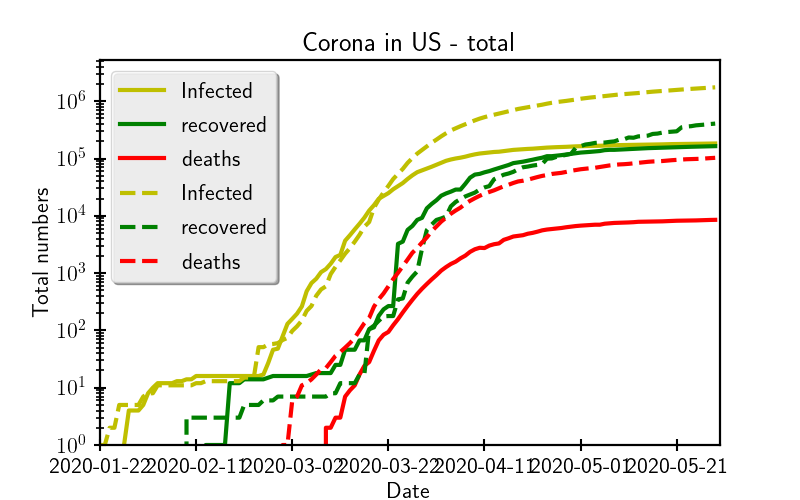

In [15]:
plt.figure(f"Overview", [8, 5], 100)
plot_data(country="Germany", state="total", log=True, ticks=20)
plot_data(country="US", state="total", log=True, ticks=20, linestyle="--")
plt.show()

### Aktuell Infiziert

<IPython.core.display.Javascript object>


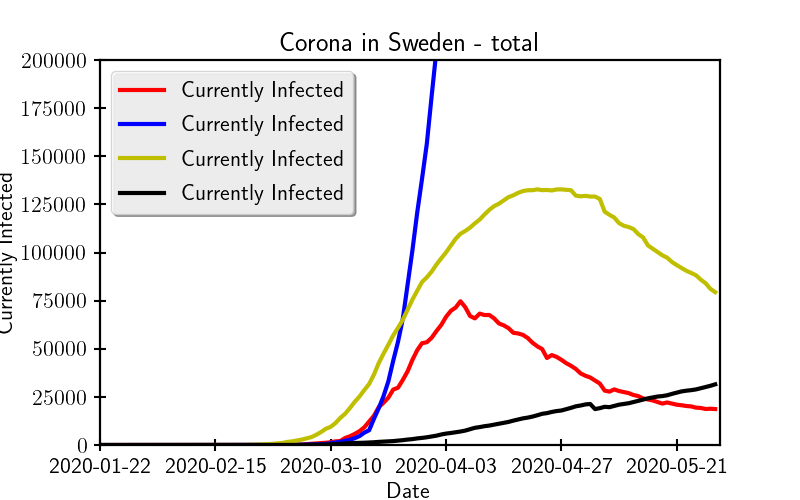

In [16]:
plt.figure(f"Infected", [8, 5], 100)
plot_current_infected(country="Germany", state="total", log=False, ticks=24, color="r")
plot_current_infected(country="US", state="total", log=False, ticks=24, color="b")
plot_current_infected(country="Italy", state="total", log=False, ticks=24, color="y")
plot_current_infected(country="Sweden", state="total", log=False, ticks=24)
plt.ylim(0, 200000)
plt.show()

### Änderung pro Tag

<IPython.core.display.Javascript object>


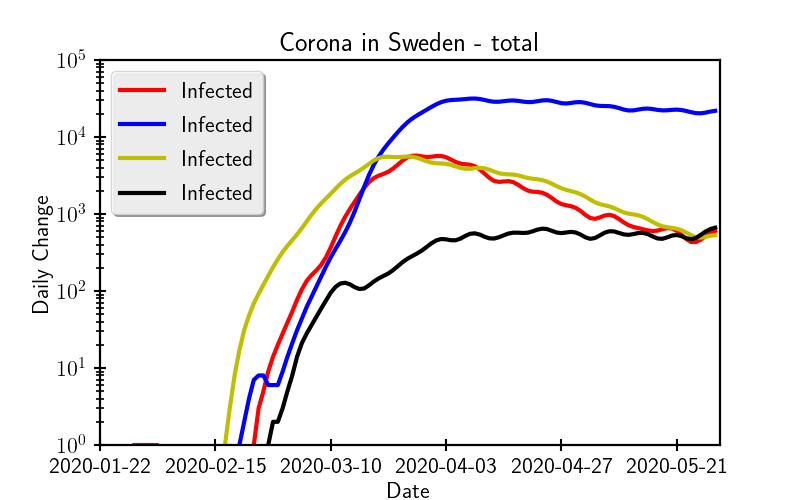

In [17]:
plt.figure(f"DataChanges", [8, 5], 100)
plot_diff(country="Germany", state="total", log=True, ticks=24, sigma=2, color="r", dtype="infected")
plot_diff(country="US", state="total", log=True, ticks=24, sigma=2, color="b", dtype="infected")
plot_diff(country="Italy", state="total", log=True, ticks=24, sigma=2, color="y", dtype="infected")
plot_diff(country="Sweden", state="total", log=True, ticks=24, sigma=2, color="k", dtype="infected")
plt.ylim(1, 1e5)
plt.show()

### Obergrenze überschritten

<IPython.core.display.Javascript object>


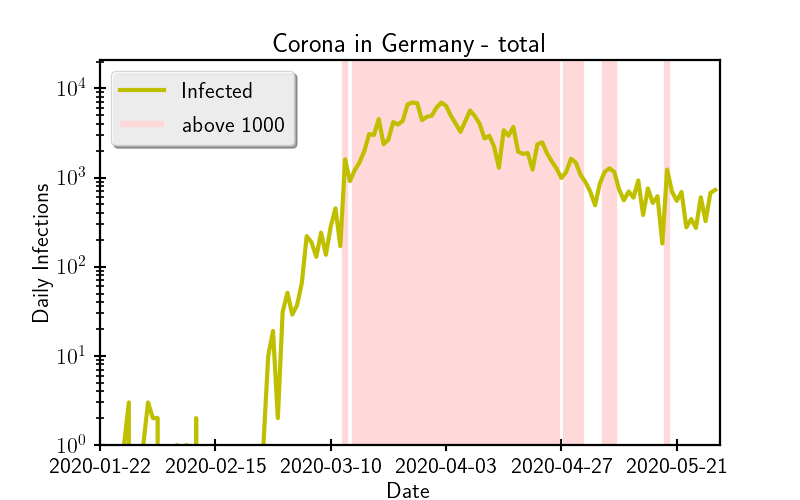

In [18]:
plt.figure(f"Treshold", [8, 5], 100)
plot_above_treshold(country="Germany", state="total", treshold=1000, log=True, ticks=24)
plt.show()

### Reproduktionszahl R
https://www.spektrum.de/news/was-verraet-die-reproduktionszahl-r-wirklich/1724660

<IPython.core.display.Javascript object>


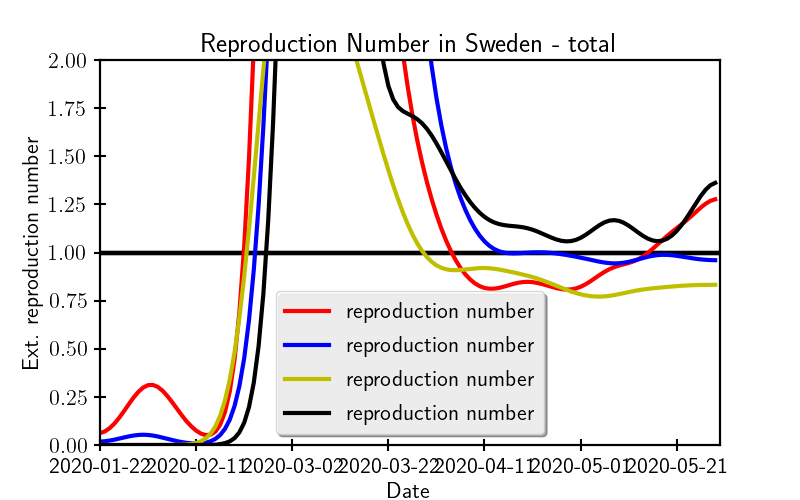

In [19]:
plt.figure(f"R", [8, 5], 100)
plot_reproduction_number("Germany", "total", sigma=5, ticks=20, yrange=(0, 2), color="r")
plot_reproduction_number("US", "total", sigma=5, ticks=20, yrange=(0, 2), color="b")
plot_reproduction_number("Italy", "total", sigma=5, ticks=20, yrange=(0, 2), color="y")
plot_reproduction_number("Sweden", "total", sigma=5, ticks=20, yrange=(0, 2), color="k")
plt.show()

<IPython.core.display.Javascript object>


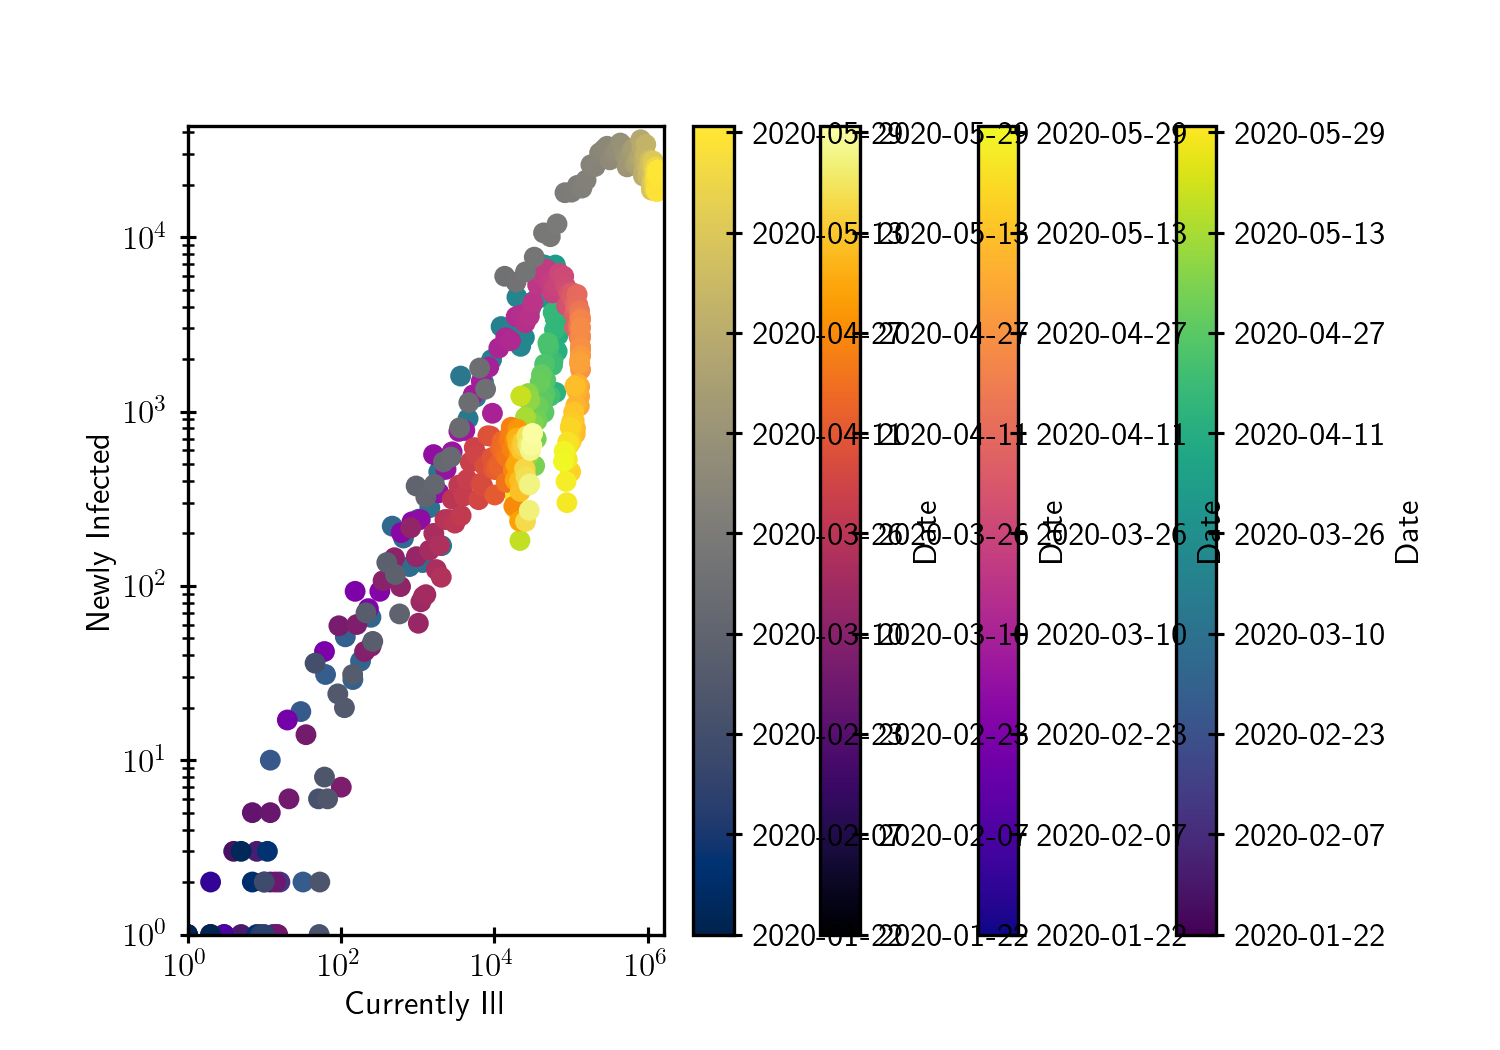

In [21]:
plt.figure(f"illvsnew")
plot_new_vs_current("Germany", "total", ticks=16, logx=True, logy=True)
plot_new_vs_current("Italy", "total", ticks=16, logx=True, logy=True, cmap="plasma")
plot_new_vs_current("Sweden", "total", ticks=16, logx=True, logy=True, cmap="inferno")
plot_new_vs_current("US", "total", ticks=16, logx=True, logy=True, cmap="cividis")
plt.show()